In [2]:
#Import Required Libraries
import tensorflow as tf
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
from pandas import ExcelWriter
from pandas import ExcelFile
import glob
from termcolor import colored
%matplotlib inline

In [3]:
#pip install termcolor

# Data Upload

In [4]:
Car_Data_Frame = pd.read_csv("2022.03.10 C-CAN 구쏘울 정상.trc", encoding='cp949')
Car_Data_Frame = Car_Data_Frame['CAN_Data'].str.split('Rx         ',n=1,expand=True)
Car_Data_Frame = Car_Data_Frame.rename(columns={0:'Time', 1:'Payload'})

#Splitting Time
Car_Data_Frame_Time = Car_Data_Frame['Time'].str.split(')',n=2,expand=True)
Car_Data_Frame_Time = Car_Data_Frame_Time.rename(columns={0:'Serial', 1:'Time'})
Car_Data_Frame_Time = Car_Data_Frame_Time.Time.astype(float)
Car_Data_Frame_Time = pd.DataFrame(Car_Data_Frame_Time).rename(columns={0:'Time'})

#Splitting Payload
Car_Data_Frame_Time_ID = Car_Data_Frame['Payload'].str.split('  ',n=2,expand=True)
Car_Data_Frame_Time_ID = Car_Data_Frame_Time_ID.rename(columns={0:'CAN_ID', 1:'DLC', 2:'Payload_8_hex'})

#Splitting Payload with each PID
Car_Data_Frame_Time_Payload_hex = Car_Data_Frame_Time_ID['Payload_8_hex'].str.split(' ',n=7,expand=True)
Car_Data_Frame_Time_Payload_hex = Car_Data_Frame_Time_Payload_hex.rename(
    columns={0:'One', 1:'Two', 2:'Three', 3:'Four', 4:'Five', 5:'Six', 6:'Seven', 7:'Eight'})

#Joind all data set
Car_Data_Frame = pd.concat([pd.DataFrame(Car_Data_Frame_Time), pd.DataFrame(Car_Data_Frame_Time_ID), 
                            pd.DataFrame(Car_Data_Frame_Time_Payload_hex)], axis=1)
Car_Data_Frame = Car_Data_Frame.sort_values(['Time'], ignore_index = True)

#Time Gap Calculation (Full_Data_Time_Gap)
Time_gap = [0]
k4 = 1
lenth = len(Car_Data_Frame)-1

for k in Car_Data_Frame.Time:
    k2 = float(Car_Data_Frame.Time[k4]) - float(k)
    Time_gap.append(k2)
    if k4 >= lenth:
        break
    k4 = k4 + 1

#Joind with time gap
Car_Data_Frame = pd.concat([pd.DataFrame(Car_Data_Frame), pd.DataFrame(Time_gap)], axis=1)
Car_Data_Frame = Car_Data_Frame.rename(columns={0:'Full_Data_Time_Gap'})
print(colored('Total Amount of Data: ', 'blue', attrs=['bold']),len(Car_Data_Frame))

Total Amount of Data:  1303127


# Overall Time Gap Change In Full Data Set

Text(0.5, 1.0, 'Data Cangeing Pattern According to Time Gap')

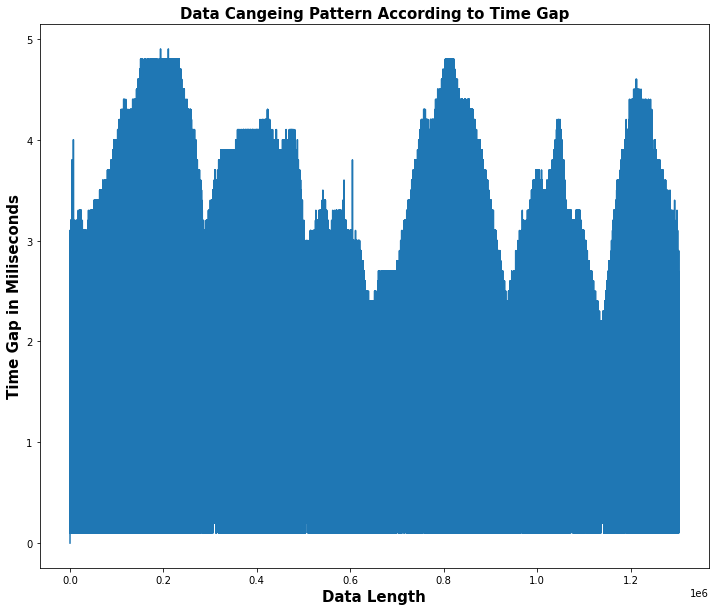

In [5]:
plt.subplots(figsize = (12, 10))
plt.plot(Car_Data_Frame['Full_Data_Time_Gap'])
plt.xlabel("Data Length", fontsize=15,  weight='bold')
plt.ylabel("Time Gap in Miliseconds", fontsize=15,  weight='bold')
plt.title("Data Cangeing Pattern According to Time Gap", fontsize=15,  weight='bold')

# Data Sliceing

In [552]:
lower_limit = 230000 #Parameter Input lower value
upper_limit = 330000 #Parameter Input higher value
column = 'Full_Data_Time_Gap' #Selecting the column

In [553]:
Car_Data_Frame[column][lower_limit:upper_limit]

230000    0.3
230001    0.2
230002    0.2
230003    0.3
230004    0.2
         ... 
329995    0.2
329996    0.2
329997    0.2
329998    0.3
329999    0.3
Name: Full_Data_Time_Gap, Length: 100000, dtype: float64

Text(0.5, 1.0, 'Sliced Data Cangeing Pattern According to Time Gap')

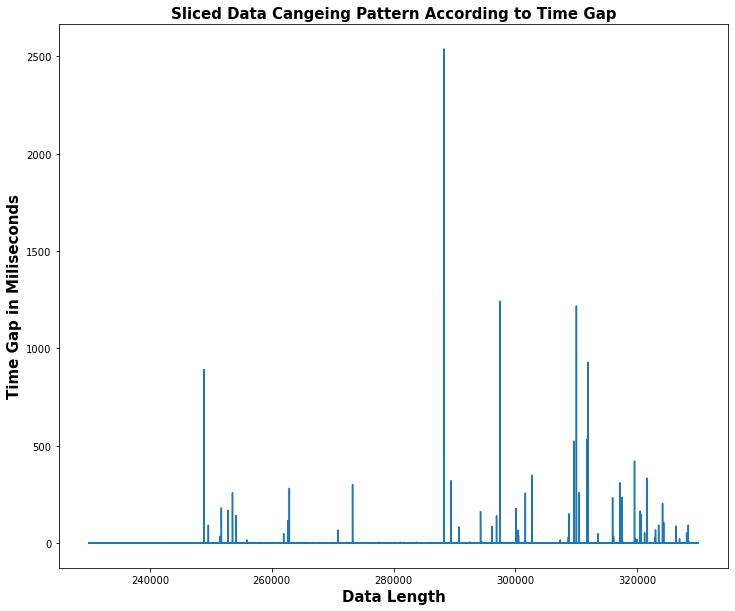

In [554]:
plt.subplots(figsize = (12, 10))
plt.plot(Car_Data_Frame[column][lower_limit:upper_limit])
plt.xlabel("Data Length", fontsize=15,  weight='bold')
plt.ylabel("Time Gap in Miliseconds", fontsize=15,  weight='bold')
plt.title("Sliced Data Cangeing Pattern According to Time Gap", fontsize=15,  weight='bold')

# ID Details

In [6]:
print((colored('All CAN ID List: \n\n', 'blue', attrs=['bold'])),np.unique(Car_Data_Frame.CAN_ID))
print('\n')
print(colored('Total Amount of CAN ID: ', 'red', attrs=['bold']),len(np.unique(Car_Data_Frame.CAN_ID)))

All CAN ID List: 

 ['0018' '0034' '0042' '0043' '0044' '0050' '0080' '0081' '00A0' '00A1'
 '0110' '0120' '0153' '0164' '0165' '018F' '01F1' '0220' '0260' '02A0'
 '02B0' '02C0' '0316' '0329' '0350' '0370' '0382' '043F' '0440' '04B0'
 '04B1' '04F0' '04F1' '04F2' '0510' '0517' '051A' '0545' '0587' '059B'
 '05A0' '05A2' '05E4' '05F0' '0690']


Total Amount of CAN ID:  45


How Many Times Used This ID

In [687]:
Total_Number_of_Used_this_ID = '0108' #Input CAN ID

In [688]:
print(colored('Total Number of Used this ID: ', 'blue', attrs=['bold']),
      len(Car_Data_Frame[Car_Data_Frame['CAN_ID'] == Total_Number_of_Used_this_ID]))

Total Number of Used this ID:  2052


Total ID used under 100 times

In [562]:
vx1 = (pd.value_counts(Car_Data_Frame['CAN_ID'])<100).index
vx2 = (pd.value_counts(Car_Data_Frame['CAN_ID'])<100).values
vx = pd.concat([pd.DataFrame(vx1), pd.DataFrame(vx2)], ignore_index=True, axis=1)
vx = vx.rename(columns={0:'ID', 1:'XXX'})
vx = vx[vx['XXX']==True]
vx = vx['ID']
print(colored('Total ID used under 3: ', 'blue', attrs=['bold']), len(vx))
print('\n')
print(colored('Total ID used under 3 List:\n\n', 'red', attrs=['bold']), vx.values)

Total ID used under 3:  7


Total ID used under 3 List:

 ['0363' '0782' '072A' '0522' '055D' '0534' '0515']


Total ID used Over 3 times

In [563]:
v1 = (pd.value_counts(Car_Data_Frame['CAN_ID'])>=100).index
v2 = (pd.value_counts(Car_Data_Frame['CAN_ID'])>=100).values
v = pd.concat([pd.DataFrame(v1), pd.DataFrame(v2)], ignore_index=True, axis=1)
v = v.rename(columns={0:'ID', 1:'XXX'})
v = v[v['XXX']==True]
v = v['ID']
print(colored('Total ID used Over 3: \n\n', 'blue', attrs=['bold']) , len(v))
print('\n')
print(colored('Total ID used Over 3 List:\n\n', 'red', attrs=['bold']), v.values)

Total ID used Over 3: 

 260


Total ID used Over 3 List:

 ['0129' '01D5' '0266' '01D8' '02E5' '01CF' '013D' '0118' '0132' '02C1'
 '0201' '02E1' '0257' '0263' '039A' '0243' '07D5' '023E' '039D' '0381'
 '03C2' '03A2' '0249' '0272' '01FB' '0282' '0221' '0393' '0545' '0372'
 '0757' '02B3' '03F5' '0207' '0359' '0281' '0123' '03C0' '0788' '0247'
 '03C3' '03E2' '06C8' '03A3' '0228' '0288' '0211' '02D1' '02C2' '0227'
 '0340' '06E8' '0139' '01F9' '0103' '0287' '0102' '03E8' '0419' '01F8'
 '07A8' '0264' '02B4' '02C4' '0439' '0224' '0343' '03DA' '038A' '0261'
 '04E2' '0241' '0360' '07DD' '0225' '0204' '020C' '0422' '0113' '077D'
 '02F9' '027D' '0252' '0292' '029D' '025D' '037A' '0212' '02D2' '0379'
 '02BD' '02A8' '0409' '02F2' '0318' '07FF' '041D' '0122' '0400' '043D'
 '02E3' '03C8' '022A' '0119' '04E3' '0339' '0458' '01FA' '0383' '0423'
 '0283' '027A' '0242' '0719' '02E8' '0448' '0428' '0279' '03F9' '078A'
 '021D' '0128' '0126' '0397' '02B6' '0395' '0108' '01D6' '0421' '0268'
 '03E3' '03A1' '0

# ID Wise Analysis On Time Gap

In [564]:
ID_based = []
for x in v:
    ID_based.append(Car_Data_Frame[Car_Data_Frame['CAN_ID']==x])
 #------------------#   
Time_Gap_by_own_ID = []
combine_data = []
k = 0
#------------------#
for i in ID_based:
    z = i['Time']
    Time_gap = [0]
    k4 = 1
    lenth = len(z)-1
    #------------------#
    for z1 in z:
        k2 = float(np.array(z)[k4]) - float(z1)
        Time_gap.append(k2)
        if k4 >= lenth:
            break
        k4 = k4 + 1
    Time_Gap_by_own_ID.append(Time_gap)
    #------------------#
for v in range(0,len(ID_based)):
    q = pd.concat([pd.DataFrame(np.array(ID_based[v])), pd.DataFrame(np.array(Time_Gap_by_own_ID[v]))], 
                  ignore_index=True, axis=1)
    q = q.rename(columns={0:'Time', 1:'CAN_ID', 2:'DLC', 3:'Full_Payload',4:'One', 5:'Two', 6:'Three', 7:'Four', 8:'Five', 
                      9:'Six', 10:'Seven', 11:'Eight', 12:'Full_Data_Time_Gap', 13:'ID_Based_Time_Gap'})
    combine_data.append(q)
    #------------------#

In [652]:
#Filter CAN ID Input
x = '0393'

In [653]:
for i in range(0,len(combine_data)):
    if combine_data[i].CAN_ID[0] == x:
        #print(combine_data[i])
        ID_value_save = combine_data[i]

In [654]:
ID_value_save

,Time,CAN_ID,DLC,Full_Payload,One,Two,Three,Four,Five,Six,Seven,Eight,Full_Data_Time_Gap,ID_Based_Time_Gap
0,35.4,0393,8,08 00 08 F9 07 C0 0E 10,08,00,08,F9,07,C0,0E,10,0.9,0.0
1,85.7,0393,8,03 80 61 00 00 00 00 00,03,80,61,00,00,00,00,00,0.2,50.3
2,135.4,0393,8,08 00 07 F9 07 C0 0E 10,08,00,07,F9,07,C0,0E,10,0.8,49.7
3,185.7,0393,8,03 80 61 00 00 00 00 00,03,80,61,00,00,00,00,00,0.3,50.3
4,235.9,0393,8,08 00 07 E9 07 C0 0E 10,08,00,07,E9,07,C0,0E,10,0.3,50.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4106,247090.0,0393,8,03 80 61 00 00 00 00 00,03,80,61,00,00,00,00,00,0.3,50.2
4107,247140.0,0393,8,08 00 07 F1 07 C0 0E 10,08,00,07,F1,07,C0,0E,10,0.3,50.0
4108,247190.0,0393,8,03 80 61 00 00 00 00 00,03,80,61,00,00,00,00,00,0.3,50.0
4109,247239.7,0393,8,08 00 07 F1 07 C0 0E 10,08,00,07,F1,07,C0,0E,10,0.2,49.7


Text(0.5, 1.0, 'Data Cangeing Pattern According to Time Gap')

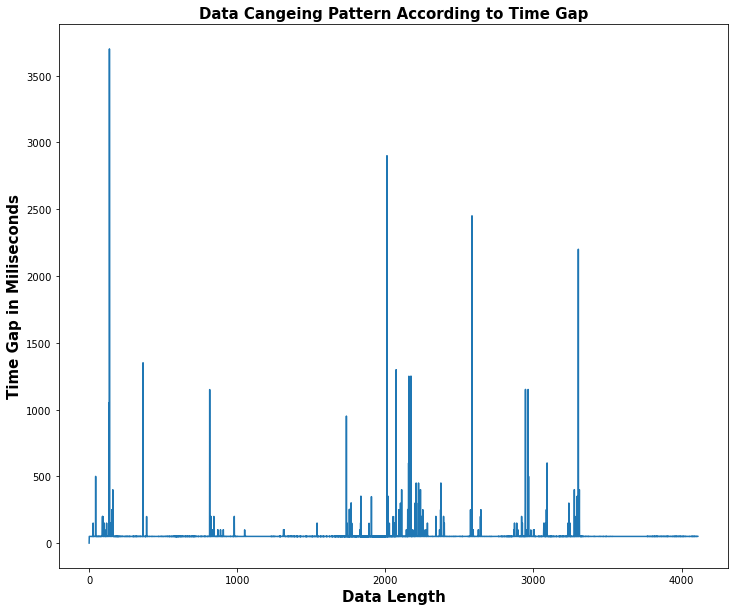

In [655]:
plt.subplots(figsize = (12, 10))
plt.plot(ID_value_save['ID_Based_Time_Gap'])
plt.xlabel("Data Length", fontsize=15,  weight='bold')
plt.ylabel("Time Gap in Miliseconds", fontsize=15,  weight='bold')
plt.title("Data Cangeing Pattern According to Time Gap", fontsize=15,  weight='bold')

# Data Sliceing on Specific CAN ID

In [656]:
lower_limit = 1000 #Parameter Input lower value
upper_limit = 1500 #Parameter Input higher value
column = 'ID_Based_Time_Gap' #Selecting the column

In [657]:
ID_value_save[column][lower_limit:upper_limit]

1000    49.4
1001    50.0
1002    50.2
1003    49.8
1004    50.2
        ... 
1495    50.6
1496    49.3
1497    50.0
1498    50.5
1499    49.7
Name: ID_Based_Time_Gap, Length: 500, dtype: float64

Text(0.5, 1.0, 'Sliced Data Cangeing Pattern According to Time Gap on ID')

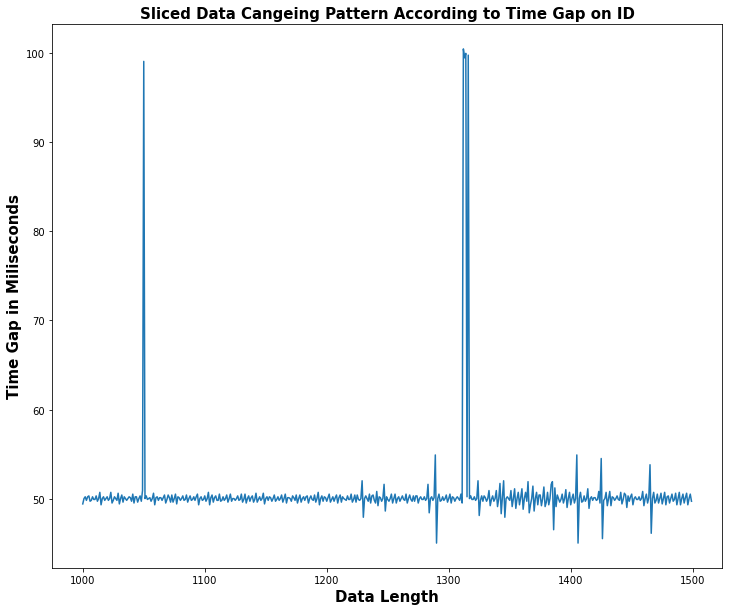

In [658]:
plt.subplots(figsize = (12, 10))
plt.plot(ID_value_save[column][lower_limit:upper_limit])
plt.xlabel("Data Length", fontsize=15,  weight='bold')
plt.ylabel("Time Gap in Miliseconds", fontsize=15,  weight='bold')
plt.title("Sliced Data Cangeing Pattern According to Time Gap on ID", fontsize=15,  weight='bold')

# Payload Analysis ID Wise

In [670]:
print(colored('Total Types of Payload Amount: \n\n', 'blue', attrs=['bold']) , len(np.unique(ID_value_save['Full_Payload'])))
print('\n')
print(colored('Total Types of Payload:\n\n', 'red', attrs=['bold']), np.unique(ID_value_save['Full_Payload'].str.strip('Full_Payload ')))

Total Types of Payload Amount: 

 12


Total Types of Payload:

 ['03 80 61 00 00 00 00 00' '08 00 06 E1 07 C0 0E 10'
 '08 00 06 E9 07 C0 0E 10' '08 00 06 F1 07 C0 0E 10'
 '08 00 06 F9 07 C0 0E 10' '08 00 07 E1 07 C0 0E 10'
 '08 00 07 E9 07 C0 0E 10' '08 00 07 F1 07 C0 0E 10'
 '08 00 07 F9 07 C0 0E 10' '08 00 08 E9 07 C0 0E 10'
 '08 00 08 F1 07 C0 0E 10' '08 00 08 F9 07 C0 0E 10']


In [671]:
single_payload = np.unique(ID_value_save['Full_Payload'].str.strip('Full_Payload '))
payload = single_payload[11] #Input payload Number

In [672]:
payload_filter_data = ID_value_save[ID_value_save['Full_Payload'].str.strip('Full_Payload ') == payload]

In [673]:
payload_filter_data

,Time,CAN_ID,DLC,Full_Payload,One,Two,Three,Four,Five,Six,Seven,Eight,Full_Data_Time_Gap,ID_Based_Time_Gap
0,35.4,0393,8,08 00 08 F9 07 C0 0E 10,08,00,08,F9,07,C0,0E,10,0.9,0.0
8,435.4,0393,8,08 00 08 F9 07 C0 0E 10,08,00,08,F9,07,C0,0E,10,0.8,49.7
14,735.4,0393,8,08 00 08 F9 07 C0 0E 10,08,00,08,F9,07,C0,0E,10,0.8,49.5
16,835.8,0393,8,08 00 08 F9 07 C0 0E 10,08,00,08,F9,07,C0,0E,10,0.2,50.4
29,1635.4,0393,8,08 00 08 F9 07 C0 0E 10,08,00,08,F9,07,C0,0E,10,0.8,48.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3965,240039.7,0393,8,08 00 08 F9 07 C0 0E 10,08,00,08,F9,07,C0,0E,10,0.3,50.1
3979,240739.6,0393,8,08 00 08 F9 07 C0 0E 10,08,00,08,F9,07,C0,0E,10,0.5,49.5
4001,241840.0,0393,8,08 00 08 F9 07 C0 0E 10,08,00,08,F9,07,C0,0E,10,0.2,49.9
4011,242341.2,0393,8,08 00 08 F9 07 C0 0E 10,08,00,08,F9,07,C0,0E,10,0.2,51.6


In [674]:
Time_gap_payload = [0]
k4 = 1
lenth = len(payload_filter_data.Time)-1

payload_filter_data['Time'] = payload_filter_data['Time'].str.extract(r'(\d+)')
strip = np.array(payload_filter_data['Time'])

for k in strip:
    k2 = float(strip[k4]) - float(k)
    Time_gap_payload.append(k2)
    if k4 >= lenth:
        break
    k4 = k4 + 1
Time_gap_payload = pd.DataFrame(Time_gap_payload, columns = ['Time_gap_payload'])

C:\Users\Lisa\AppData\Local\Temp/ipykernel_1944/1409731883.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  payload_filter_data['Time'] = payload_filter_data['Time'].str.extract(r'(\d+)')


In [675]:
Time_gap_payload

,Time_gap_payload
0,0.0
1,400.0
2,300.0
3,100.0
4,800.0
...,...
186,500.0
187,700.0
188,1101.0
189,501.0


Text(0.5, 1.0, 'Payload According to Time Gap')

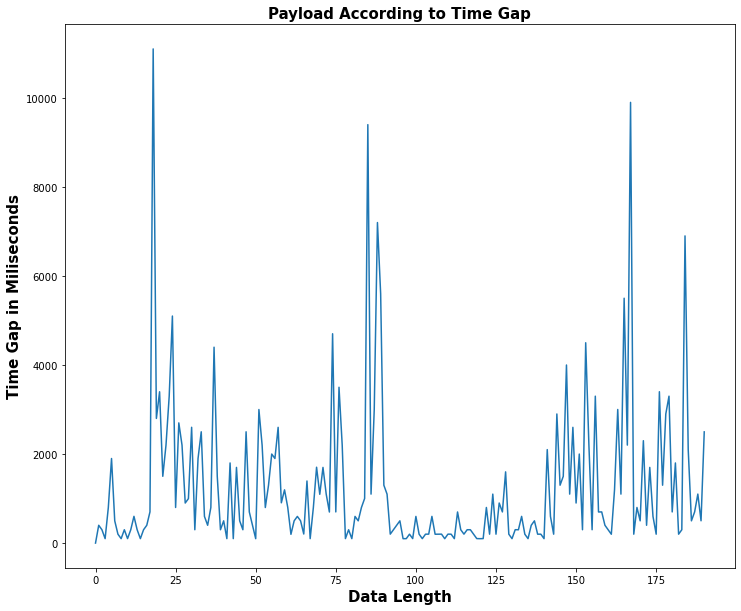

In [676]:
plt.subplots(figsize = (12, 10))
plt.plot(Time_gap_payload['Time_gap_payload'])
plt.xlabel("Data Length", fontsize=15,  weight='bold')
plt.ylabel("Time Gap in Miliseconds", fontsize=15,  weight='bold')
plt.title("Payload According to Time Gap", fontsize=15,  weight='bold')

# PID Analysis ID Wise

In [679]:
Which_PID = 'One' # Input PID Column

In [680]:
print(colored('Total Types of Payload Amount: \n\n', 'blue', attrs=['bold']) , len(np.unique(ID_value_save[Which_PID])))
print('\n')
print(colored('Total Types of Payload:\n\n', 'red', attrs=['bold']), np.unique(ID_value_save[Which_PID].str.strip('Full_Payload ')))

Total Types of Payload Amount: 

 2


Total Types of Payload:

 ['03' '08']


In [681]:
PID = '03' # Input PID Payload

In [682]:
PID_filter_data = ID_value_save[ID_value_save['One'].str.strip('One ') == PID]

In [683]:
PID_filter_data

,Time,CAN_ID,DLC,Full_Payload,One,Two,Three,Four,Five,Six,Seven,Eight,Full_Data_Time_Gap,ID_Based_Time_Gap
1,85.7,0393,8,03 80 61 00 00 00 00 00,03,80,61,00,00,00,00,00,0.2,50.3
3,185.7,0393,8,03 80 61 00 00 00 00 00,03,80,61,00,00,00,00,00,0.3,50.3
5,285.4,0393,8,03 80 61 00 00 00 00 00,03,80,61,00,00,00,00,00,1.3,49.5
7,385.7,0393,8,03 80 61 00 00 00 00 00,03,80,61,00,00,00,00,00,0.3,50.1
9,485.4,0393,8,03 80 61 00 00 00 00 00,03,80,61,00,00,00,00,00,1.3,50.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4102,246889.8,0393,8,03 80 61 00 00 00 00 00,03,80,61,00,00,00,00,00,0.3,48.5
4104,246990.0,0393,8,03 80 61 00 00 00 00 00,03,80,61,00,00,00,00,00,0.2,50.2
4106,247090.0,0393,8,03 80 61 00 00 00 00 00,03,80,61,00,00,00,00,00,0.3,50.2
4108,247190.0,0393,8,03 80 61 00 00 00 00 00,03,80,61,00,00,00,00,00,0.3,50.0


In [684]:
#PID Payload Timegap
Time_gap_payload = [0]
k4 = 1
lenth = len(payload_filter_data.Time)-1

PID_filter_data[Which_PID] = PID_filter_data[Which_PID].str.extract(r'(\d+)')

for k in strip:
    k2 = float(strip[k4]) - float(k)
    Time_gap_payload.append(k2)
    if k4 >= lenth:
        break
    k4 = k4 + 1
Time_gap_PID = pd.DataFrame(Time_gap_payload, columns = ['Time_gap_PID'])

C:\Users\Lisa\AppData\Local\Temp/ipykernel_1944/3900333277.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  PID_filter_data[Which_PID] = PID_filter_data[Which_PID].str.extract(r'(\d+)')


In [685]:
Time_gap_PID

,Time_gap_PID
0,0.0
1,400.0
2,300.0
3,100.0
4,800.0
...,...
186,500.0
187,700.0
188,1101.0
189,501.0


Text(0.5, 1.0, 'PID According to Time Gap')

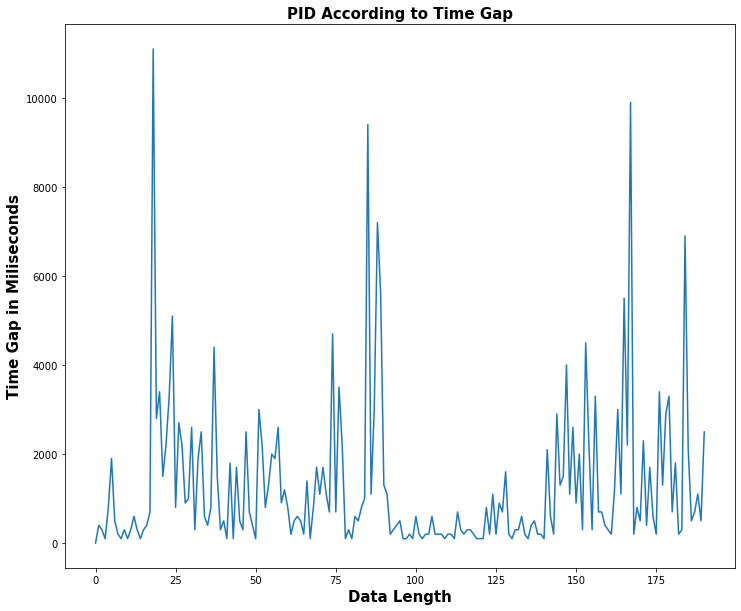

In [686]:
plt.subplots(figsize = (12, 10))
plt.plot(Time_gap_PID['Time_gap_PID'])
plt.xlabel("Data Length", fontsize=15,  weight='bold')
plt.ylabel("Time Gap in Miliseconds", fontsize=15,  weight='bold')
plt.title("PID According to Time Gap", fontsize=15,  weight='bold')